## Dataset loading & visualization

In [29]:
import sys
import os
import json
from PIL import Image
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torchvision.ops as ops
import math
import random
from dotenv import load_dotenv

load_dotenv()
YT_ROOTS = [os.getenv("YT_ROOT_1"), os.getenv("YT_ROOT_2")]


def extract_bbox_from_points(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    return [x1, y1, x2 - x1, y2 - y1]  # x, y, w, h


def get_brake_status(raw):
    if "BrakeOn" in raw:
        return "brake_on"
    if "BrakeOff" in raw:
        return "brake_off"
    return "unknown"


def get_turn_signal(ts):
    if ts == "left":
        return "left_signal"
    if ts == "right":
        return "right_signal"
    if ts == "hazard":
        return "hazard"
    if ts == "off":
        return "off"
    return "unknown"


def normalize_label(shape):
    raw = shape["label"]
    ts = shape.get("attributes", {}).get("turn_signal", "")
    return get_brake_status(raw), get_turn_signal(ts)


def process_json(json_path):
    img_path = json_path[:-5] + ".jpg"
    if not os.path.exists(img_path):
        return None

    try:
        with open(json_path, "r") as f:
            ann = json.load(f)
    except:
        return None

    objects = []
    for shape in ann.get("shapes", []):
        bbox = extract_bbox_from_points(shape["points"])
        brake_status, turn_signal = normalize_label(shape)
        if brake_status != "unknown":
            objects.append({"bbox": bbox, "label": brake_status})
        if turn_signal not in ["unknown", "off"]:
            objects.append({"bbox": bbox, "label": turn_signal})

    return {"image_path": img_path, "objects": objects}


def load_yt_dataset_fast(root_dirs, max_workers=16):
    json_files = [
        os.path.join(dirpath, f)
        for root in root_dirs
        for dirpath, _, filenames in os.walk(root)
        for f in filenames
        if f.lower().endswith(".json")
    ]
    print("finished finding all JSON files")

    samples = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_json, jf): jf for jf in json_files}
        for idx, future in enumerate(as_completed(futures)):
            res = future.result()
            if res:
                samples.append(res)
            if (idx + 1) % 1000 == 0:
                print(f"Processed {idx+1} / {len(json_files)} JSON files")

    return samples

In [30]:
print('starting to load YT dataset...')
samples = load_yt_dataset_fast(YT_ROOTS)
print("Total samples:", len(samples))


starting to load YT dataset...
finished finding all JSON files
Processed 1000 / 111800 JSON files
Processed 2000 / 111800 JSON files
Processed 3000 / 111800 JSON files
Processed 4000 / 111800 JSON files
Processed 5000 / 111800 JSON files
Processed 6000 / 111800 JSON files
Processed 7000 / 111800 JSON files
Processed 8000 / 111800 JSON files
Processed 9000 / 111800 JSON files
Processed 10000 / 111800 JSON files
Processed 11000 / 111800 JSON files
Processed 12000 / 111800 JSON files
Processed 13000 / 111800 JSON files
Processed 14000 / 111800 JSON files
Processed 15000 / 111800 JSON files
Processed 16000 / 111800 JSON files
Processed 17000 / 111800 JSON files
Processed 18000 / 111800 JSON files
Processed 19000 / 111800 JSON files
Processed 20000 / 111800 JSON files
Processed 21000 / 111800 JSON files
Processed 22000 / 111800 JSON files
Processed 23000 / 111800 JSON files
Processed 24000 / 111800 JSON files
Processed 25000 / 111800 JSON files
Processed 26000 / 111800 JSON files
Processed 

## Zero-shot OWL-ViT evaluation (visualization is at the bottom with fine tuned model)

In [31]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model.to(device)
model.eval()

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

Where does OWL-ViT fail in this safety-critical scenario?


In [52]:
# Define your label mapping
label_map = {
    "brake_off": "car with brake light off",
    "brake_on": "car with brake light on",
    "left_signal": "car with left signal on",
    "right_signal": "car with right signal on",
    "hazard": "car with hazard lights on",
}

# IMPORTANT: Keep consistent ordering
label_to_idx = {key: idx for idx, key in enumerate(label_map.keys())}
text_queries = [label_map[key] for key in label_map.keys()]  # Use keys to ensure order matches

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

# Verification
print("\n" + "="*60)
print("VERIFICATION: Label Mapping")
print("="*60)
print(f"label_to_idx: {label_to_idx}")
print(f"\ntext_queries order:")
for idx, key in enumerate(label_map.keys()):
    print(f"  Index {idx}: {key} -> '{label_map[key]}'")
print("="*60 + "\n")


class OwlViTDataset(Dataset):
    def __init__(self, records, label_map, min_boxes=1):
        self.label_map = label_map
        self.records = [
            record
            for record in records
            if sum(obj["label"] in label_map for obj in record["objects"]) >= min_boxes
        ]
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        item = self.records[idx]
        img_path = item["image_path"]
        objects = item["objects"]

        image = Image.open(img_path).convert("RGB")
        width, height = image.size

        boxes = []
        labels_idx = []
        for obj in objects:
            class_name = obj["label"]
            if class_name not in self.label_map:
                continue

            x, y, w, h = obj["bbox"]
            x1 = max(x / width, 0.0)
            y1 = max(y / height, 0.0)
            x2 = min((x + w) / width, 1.0)
            y2 = min((y + h) / height, 1.0)

            boxes.append([float(x1), float(y1), float(x2), float(y2)])
            labels_idx.append(self.label_to_idx[class_name])

        if boxes:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        else:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)

        if labels_idx:
            labels_tensor = torch.tensor(labels_idx, dtype=torch.long)
        else:
            labels_tensor = torch.zeros((0,), dtype=torch.long)

        return {
            "image": image,
            "boxes": boxes_tensor,
            "labels": labels_tensor,
            "image_path": img_path,
            "size": (height, width),
        }


VERIFICATION: Label Mapping
label_to_idx: {'brake_off': 0, 'brake_on': 1, 'left_signal': 2, 'right_signal': 3, 'hazard': 4}

text_queries order:
  Index 0: brake_off -> 'car with brake light off'
  Index 1: brake_on -> 'car with brake light on'
  Index 2: left_signal -> 'car with left signal on'
  Index 3: right_signal -> 'car with right signal on'
  Index 4: hazard -> 'car with hazard lights on'



In [53]:
def train_val_split(records, train_ratio=0.85, seed=42):
    indices = list(range(len(records)))
    random.Random(seed).shuffle(indices)
    split_idx = max(1, int(len(indices) * train_ratio))
    train_records = [records[i] for i in indices[:split_idx]]
    val_records = [records[i] for i in indices[split_idx:]]
    if not val_records:
        val_records = train_records[-1:]
        train_records = train_records[:-1]
    return train_records, val_records


def owlvit_collate_fn(batch):
    images = [item["image"] for item in batch]
    batch_text = [text_queries] * len(images)
    encoded = processor(images=images, text=batch_text, return_tensors="pt", padding=True)

    return {
        "pixel_values": encoded["pixel_values"],
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "gt_boxes": [item["boxes"] for item in batch],
        "gt_labels": [item["labels"] for item in batch],
        "image_paths": [item["image_path"] for item in batch],
    }


def cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


def xyxy_to_cxcywh(boxes):
    x1, y1, x2, y2 = boxes.unbind(-1)
    w = x2 - x1
    h = y2 - y1
    cx = x1 + 0.5 * w
    cy = y1 + 0.5 * h
    return torch.stack([cx, cy, w, h], dim=-1)


def owlvit_detection_loss(outputs, gt_boxes, gt_labels, cls_weight=1.0, box_weight=2.0, iou_weight=1.0):
    pred_boxes = outputs.pred_boxes
    pred_logits = outputs.logits
    device = pred_boxes.device
    total_loss = torch.zeros(1, device=device)
    matched_batches = 0

    for batch_idx in range(len(gt_boxes)):
        boxes = gt_boxes[batch_idx].to(device)
        labels = gt_labels[batch_idx].to(device)
        if boxes.numel() == 0:
            continue

        preds_xyxy = cxcywh_to_xyxy(pred_boxes[batch_idx])
        ious = ops.box_iou(preds_xyxy, boxes)
        best_idx = torch.argmax(ious, dim=0)
        matched_logits = pred_logits[batch_idx][best_idx]
        cls_loss = F.cross_entropy(matched_logits, labels)

        pred_cxcywh = pred_boxes[batch_idx][best_idx]
        target_cxcywh = xyxy_to_cxcywh(boxes)
        box_loss = F.l1_loss(pred_cxcywh, target_cxcywh)

        matched_ious = ious[best_idx, torch.arange(len(boxes), device=device)]
        iou_loss = (1.0 - matched_ious.clamp(0.0, 1.0)).mean()

        total_loss = total_loss + cls_weight * cls_loss + box_weight * box_loss + iou_weight * iou_loss
        matched_batches += 1

    if matched_batches == 0:
        return total_loss

    return total_loss / matched_batches

In [54]:
train_records, val_records = train_val_split(samples, train_ratio=0.70, seed=42)
train_dataset = OwlViTDataset(train_records, label_map)
val_dataset = OwlViTDataset(val_records, label_map)

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

Train samples: 54412 | Val samples: 23341


## Fine-tuning setup

In [55]:
batch_size = 16
num_epochs = 4
learning_rate = 5e-6
weight_decay = 0.01
grad_clip = 1.0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=owlvit_collate_fn,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=owlvit_collate_fn,
    num_workers=0,
)

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_train_steps = max(1, len(train_loader) * num_epochs)
scheduler = CosineAnnealingLR(optimizer, T_max=total_train_steps)

In [63]:
def run_epoch(data_loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    steps = 0
    loop = tqdm(data_loader, desc="train" if train else "val", leave=False)

    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                attention_mask=attention_mask,
            )
            loss = owlvit_detection_loss(
                outputs,
                gt_boxes=batch["gt_boxes"],
                gt_labels=batch["gt_labels"],
            )

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

        epoch_loss += loss.item()
        steps += 1
        loop.set_postfix(loss=epoch_loss / max(1, steps))

    return epoch_loss / max(1, steps)

#uncomment for training
for epoch in range(num_epochs):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch + 1}/{num_epochs} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")

train:   0%|          | 0/3401 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
save_dir = os.path.join("artifacts", f"owlvit-finetune")
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print(f"Saved fine-tuned OWL-ViT artifacts to {save_dir}")

SafetensorError: Error while serializing: I/O error: The requested operation cannot be performed on a file with a user-mapped section open. (os error 1224)

In [58]:
ckpt_dir = "artifacts/owlvit-finetune" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

finetuned_processor = OwlViTProcessor.from_pretrained(ckpt_dir)
finetuned_model = OwlViTForObjectDetection.from_pretrained(ckpt_dir).to(device)
finetuned_model.eval()

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

In [77]:
def compute_iou(boxA, boxB):
    """
    boxA, boxB: tensors of shape [4] in absolute pixel coords [x1, y1, x2, y2]
    """
    x1 = torch.max(boxA[0], boxB[0])
    y1 = torch.max(boxA[1], boxB[1])
    x2 = torch.min(boxA[2], boxB[2])
    y2 = torch.min(boxA[3], boxB[3])

    inter_w = torch.clamp(x2 - x1, min=0)
    inter_h = torch.clamp(y2 - y1, min=0)
    inter_area = inter_w * inter_h

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter_area + 1e-6

    return inter_area / union

def compute_map(gt_boxes, gt_labels, pred_boxes, pred_scores, pred_labels, iou_thresh=0.5):
    """
    Compute mAP for a SINGLE IMAGE using simplified AP calculation.
    """
    if len(gt_boxes) == 0:
        return 1.0 if len(pred_boxes) == 0 else 0.0
    if len(pred_boxes) == 0:
        return 0.0

    aps = []
    classes = torch.unique(gt_labels)  # Only compute AP for classes that have GT
    
    # print(f"  DEBUG: GT classes present: {classes.tolist()}")
    # print(f"  DEBUG: Pred classes present: {torch.unique(pred_labels).tolist() if len(pred_labels) > 0 else []}")
    # print(f"  DEBUG: GT labels: {gt_labels.tolist()}")
    # print(f"  DEBUG: Pred labels: {pred_labels.tolist()}")
    
    for cls in classes:
        gt_mask = (gt_labels == cls)
        pred_mask = (pred_labels == cls)

        cls_gt = gt_boxes[gt_mask]
        cls_pred = pred_boxes[pred_mask]
        cls_scores = pred_scores[pred_mask]

        num_gt = len(cls_gt)
        
        # print(f"  DEBUG: Class {cls}: {num_gt} GT boxes, {len(cls_pred)} pred boxes")
        
        if len(cls_pred) == 0:
            aps.append(0.0)
            continue

        # Sort predictions by confidence
        sorted_idx = torch.argsort(cls_scores, descending=True)
        cls_pred = cls_pred[sorted_idx]

        tp = []
        fp = []
        matched = set()

        for i, pbox in enumerate(cls_pred):
            best_iou = 0.0
            best_gt_idx = -1
            
            for gt_idx, gbox in enumerate(cls_gt):
                if gt_idx in matched:
                    continue
                iou = compute_iou(pbox, gbox).item()
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
            
            if best_iou >= iou_thresh:
                tp.append(1)
                fp.append(0)
                matched.add(best_gt_idx)
            else:
                tp.append(0)
                fp.append(1)

        # Compute precision-recall curve
        tp_cum = torch.cumsum(torch.tensor(tp, dtype=torch.float32), dim=0)
        fp_cum = torch.cumsum(torch.tensor(fp, dtype=torch.float32), dim=0)
        
        recall = tp_cum / num_gt
        precision = tp_cum / (tp_cum + fp_cum)

        # Compute AP (area under P-R curve)
        # Add boundary points
        recall = torch.cat([torch.tensor([0.0]), recall])
        precision = torch.cat([torch.tensor([0.0]), precision])
        
        # Compute area
        ap = 0.0
        for i in range(1, len(recall)):
            ap += (recall[i] - recall[i-1]) * precision[i]
        
        # print(f"  DEBUG: Class {cls} AP: {ap:.4f}")
        aps.append(ap)

    mAP = sum(aps) / len(aps) if aps else 0.0
    # print(f"  DEBUG: Final mAP: {mAP:.4f} (averaged over {len(aps)} classes)")
    return mAP

def compute_recall(gt_boxes, pred_boxes, pred_scores, pred_labels, iou_thresh=0.5):
    """
    Recall = correctly detected GT boxes / all GT boxes
    """
    if len(gt_boxes) == 0:
        return 1.0

    detected = 0

    for g in gt_boxes:
        if len(pred_boxes) == 0:
            continue

        ious = torch.tensor([compute_iou(g, p) for p in pred_boxes])
        if torch.max(ious) >= iou_thresh:
            detected += 1

    return detected / len(gt_boxes)

def compute_state_accuracy(gt_boxes, gt_labels, pred_boxes, pred_labels, iou_thresh=0.5):
    """
    Percentage of detections that got the correct CLASS / STATE
    (only counted if IoU matched)
    """
    if len(pred_boxes) == 0:
        return 0.0

    correct = 0
    total = 0

    for i, pbox in enumerate(pred_boxes):
        ious = torch.tensor([compute_iou(pbox, gbox) for gbox in gt_boxes])
        max_iou, argmax_iou = torch.max(ious, dim=0)

        if max_iou >= iou_thresh:
            total += 1
            if pred_labels[i] == gt_labels[argmax_iou]:
                correct += 1

    if total == 0:
        return 0.0

    return correct / total



## Fine-tuning results (metrics + plots + qualitative examples)

In [76]:
def visualize_owlvit_with_ground_truth(
    processor,
    model,
    dataset_item,
    text_queries,
    threshold: float = 0.1,
    device=None,
    figsize=(12, 8),
    apply_nms: bool = True,
    nms_iou_threshold: float = 0.2,
    iou_thresh: float = 0.5,
):
    """
    Run OWL-ViT on an image and display both predictions and ground truth boxes.
    Also computes and prints mAP, Recall, and State Accuracy.
    
    IMPORTANT: text_queries must be ordered to match the dataset's label_to_idx mapping!
    """
    image = dataset_item["image"]
    gt_boxes = dataset_item["boxes"]
    gt_labels = dataset_item["labels"]
    height, width = dataset_item["size"]

    device = device or next(model.parameters()).device

    # Run model inference
    inputs = processor(text=text_queries, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([(height, width)], device=device)

    result = processor.post_process_grounded_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        threshold=float(threshold),
        text_labels=[text_queries],
    )[0]

    # Convert GT boxes to pixel coordinates for metrics
    gt_boxes_pixels = gt_boxes.clone()
    gt_boxes_pixels[:, [0, 2]] *= width
    gt_boxes_pixels[:, [1, 3]] *= height

    # Get predictions
    pred_boxes = result["boxes"].detach().cpu() if "boxes" in result and len(result["boxes"]) > 0 else torch.zeros((0, 4))
    pred_scores = result["scores"].detach().cpu() if "scores" in result and len(result["scores"]) > 0 else torch.zeros((0,))
    pred_labels = result["labels"].detach().cpu() if "labels" in result and len(result["labels"]) > 0 else torch.zeros((0,), dtype=torch.long)

    # Apply NMS if requested
    if apply_nms and len(pred_boxes) > 0:
        keep_indices_list = []
        for cls in pred_labels.unique():
            cls_mask = pred_labels == cls
            cls_inds = torch.nonzero(cls_mask, as_tuple=True)[0]
            kept = ops.nms(pred_boxes[cls_inds], pred_scores[cls_inds], float(nms_iou_threshold))
            keep_indices_list.append(cls_inds[kept])
        if keep_indices_list:
            keep_idx = torch.cat(keep_indices_list)
            keep_idx = keep_idx[torch.argsort(pred_scores[keep_idx], descending=True)]
            pred_boxes = pred_boxes[keep_idx]
            pred_scores = pred_scores[keep_idx]
            pred_labels = pred_labels[keep_idx]

    # Compute metrics
    map_score = compute_map(gt_boxes_pixels, gt_labels, pred_boxes, pred_scores, pred_labels, iou_thresh=0.1)
    recall_score = compute_recall(gt_boxes_pixels, pred_boxes, pred_scores, pred_labels, iou_thresh=iou_thresh)
    state_acc = compute_state_accuracy(gt_boxes_pixels, gt_labels, pred_boxes, pred_labels, iou_thresh=iou_thresh)

    # Print metrics
    print(f"  mAP@{iou_thresh}: {map_score:.4f}")
    print(f"  Recall@{iou_thresh}: {recall_score:.4f}")
    print(f"  State Accuracy@{iou_thresh}: {state_acc:.4f}")
    print(f"  GT boxes: {len(gt_boxes)} | Pred boxes: {len(pred_boxes)}")

    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(image)

    # Draw ground truth boxes (RED)
    if len(gt_boxes) > 0:
        for box, label_idx in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box.tolist()
            x1, x2 = x1 * width, x2 * width
            y1, y2 = y1 * height, y2 * height
            w, h = x2 - x1, y2 - y1
            
            rect = patches.Rectangle(
                (x1, y1), w, h, linewidth=2, edgecolor="red", facecolor="none", linestyle="--"
            )
            ax.add_patch(rect)
            label_text = f"GT: {text_queries[int(label_idx)]}"
            ax.text(
                x1,
                max(0, y1 - 5),
                label_text,
                fontsize=9,
                color="white",
                bbox=dict(facecolor="red", alpha=0.7, edgecolor="none"),
            )

    # Draw predicted boxes (GREEN)
    if len(pred_boxes) > 0:
        for box, score, label_idx in zip(pred_boxes, pred_scores, pred_labels):
            x1, y1, x2, y2 = box.tolist()
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h, linewidth=2, edgecolor="lime", facecolor="none"
            )
            ax.add_patch(rect)
            label_text = f"Pred: {text_queries[int(label_idx)]}: {score:.2f}"
            ax.text(
                x1,
                y2 + 5,
                label_text,
                fontsize=9,
                color="black",
                bbox=dict(facecolor="yellow", alpha=0.7, edgecolor="none"),
            )

    ax.set_title(f"Red (dashed) = GT | Green (solid) = Pred | mAP: {map_score:.3f} | Recall: {recall_score:.3f} | State Acc: {state_acc:.3f}")
    ax.axis("off")
    plt.show()


Image 19674: C:\Users\18438\Downloads\TLD-YT-part1\CN9j5MvjC8w\CN9j5MvjC8w-part8\000004446.jpg

Pretrained model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.0000
  State Accuracy@0.2: 0.0000
  GT boxes: 1 | Pred boxes: 0


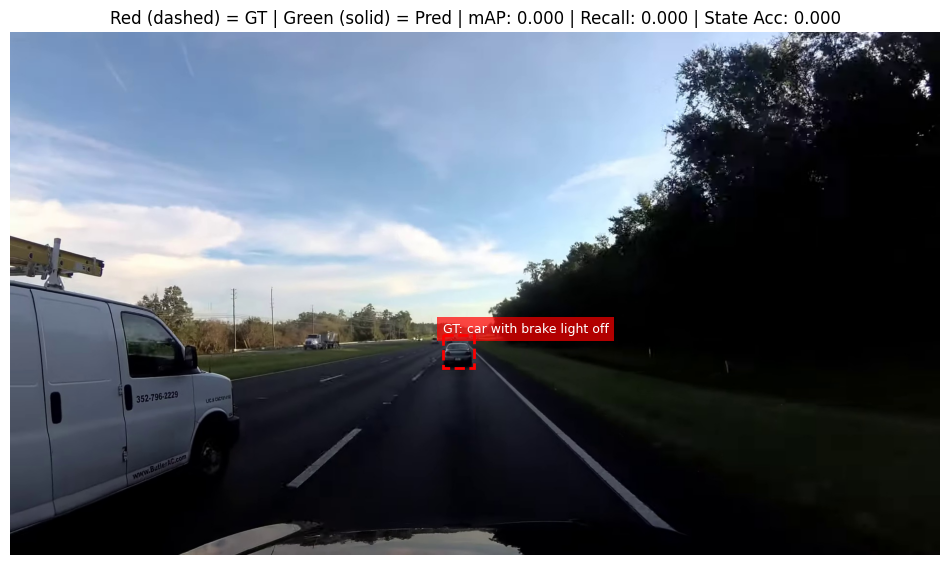


Fine-tuned model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.0000
  State Accuracy@0.2: 0.0000
  GT boxes: 1 | Pred boxes: 0


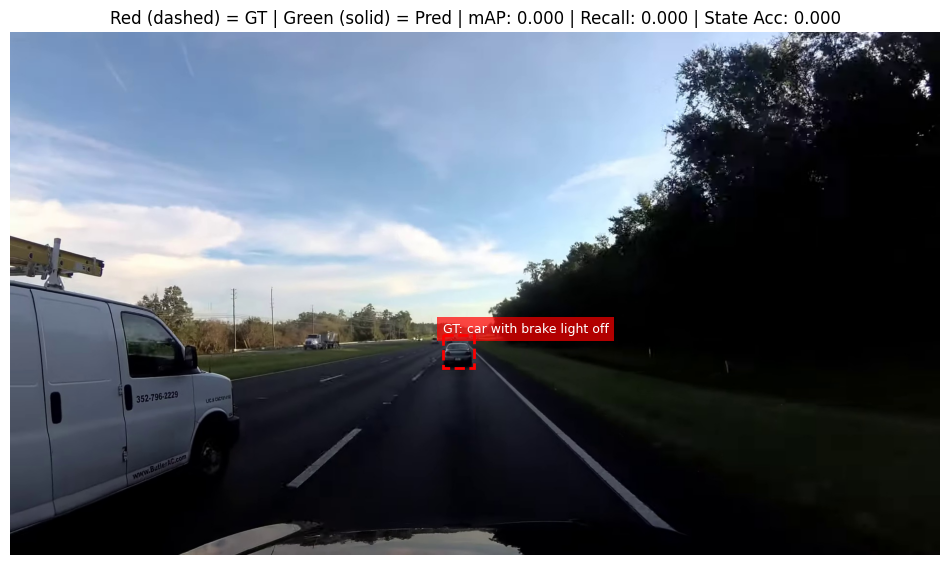


Image 321: C:\Users\18438\Downloads\TLD-YT-part1\CQtE8-EoOvQ\CQtE8-EoOvQ-part1\000000146.jpg

Pretrained model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.2857
  State Accuracy@0.2: 0.0000
  GT boxes: 7 | Pred boxes: 2


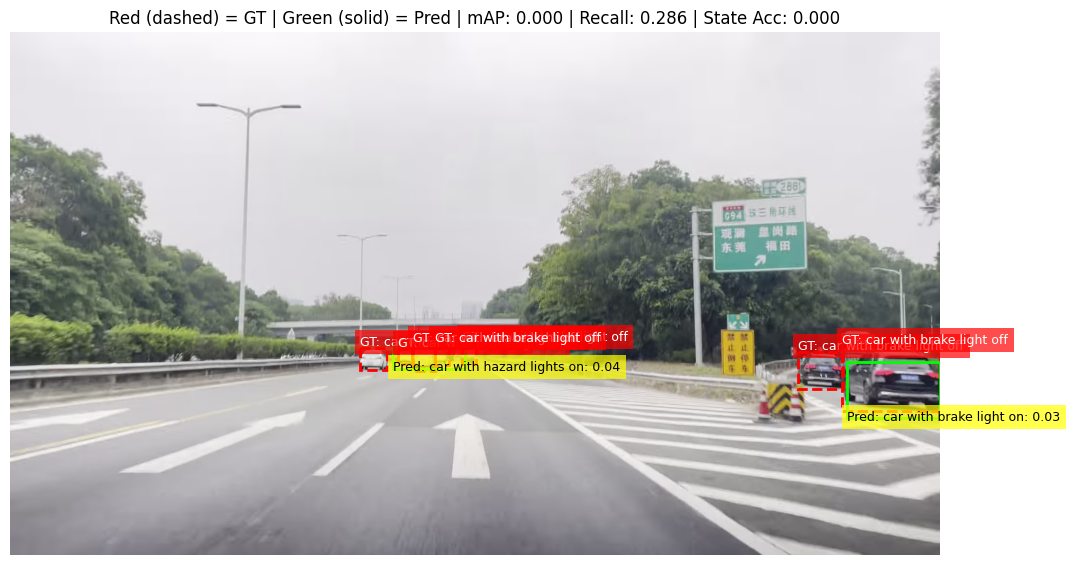


Fine-tuned model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.2857
  State Accuracy@0.2: 0.0000
  GT boxes: 7 | Pred boxes: 4


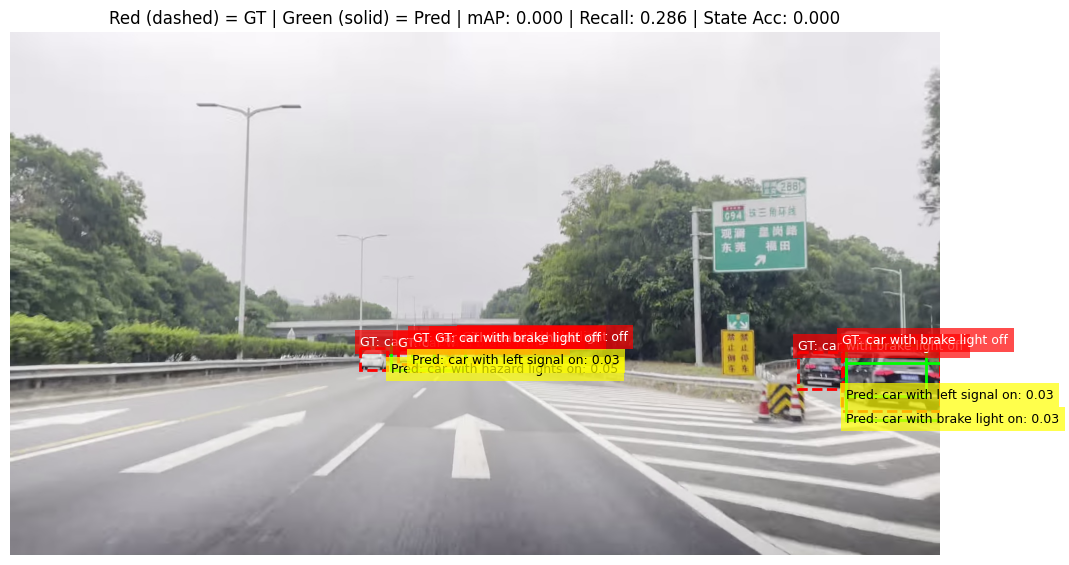


Image 9: C:\Users\18438\Downloads\TLD-YT-part1\C0h4SEjedlA\C0h4SEjedlA-part1\000000112.jpg

Pretrained model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.2500
  State Accuracy@0.2: 0.0000
  GT boxes: 4 | Pred boxes: 2


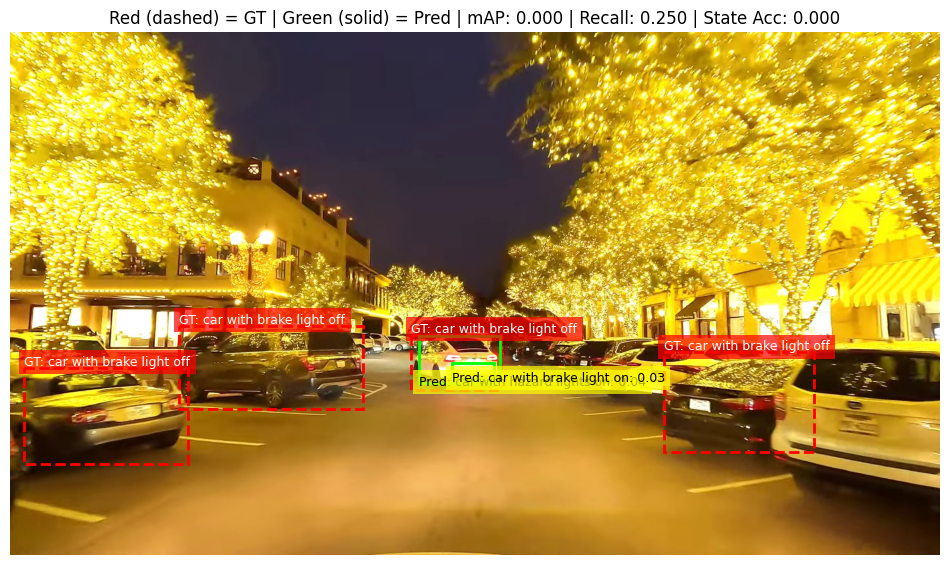


Fine-tuned model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.2500
  State Accuracy@0.2: 0.0000
  GT boxes: 4 | Pred boxes: 2


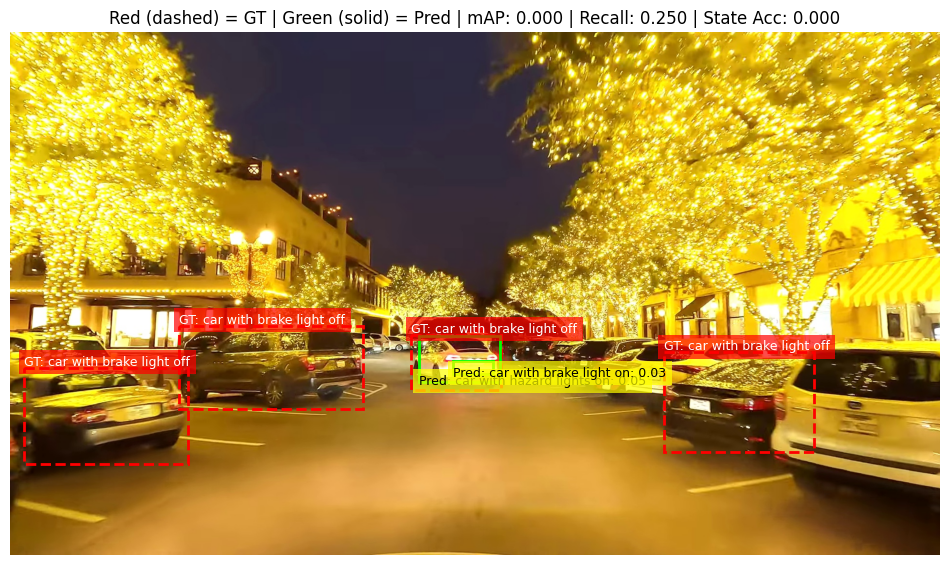


Image 5228: C:\Users\18438\Downloads\TLD-YT-part1\DmkoYs7Bip8\DmkoYs7Bip8-part6\000002858.jpg

Pretrained model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.0000
  State Accuracy@0.2: 0.0000
  GT boxes: 5 | Pred boxes: 1


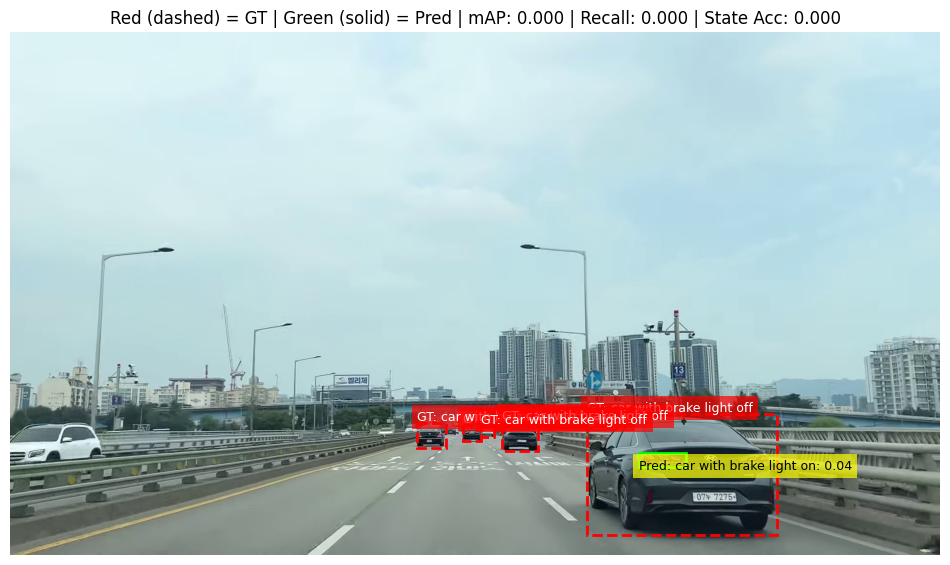


Fine-tuned model:
  mAP@0.2: 0.0000
  Recall@0.2: 0.2000
  State Accuracy@0.2: 0.0000
  GT boxes: 5 | Pred boxes: 3


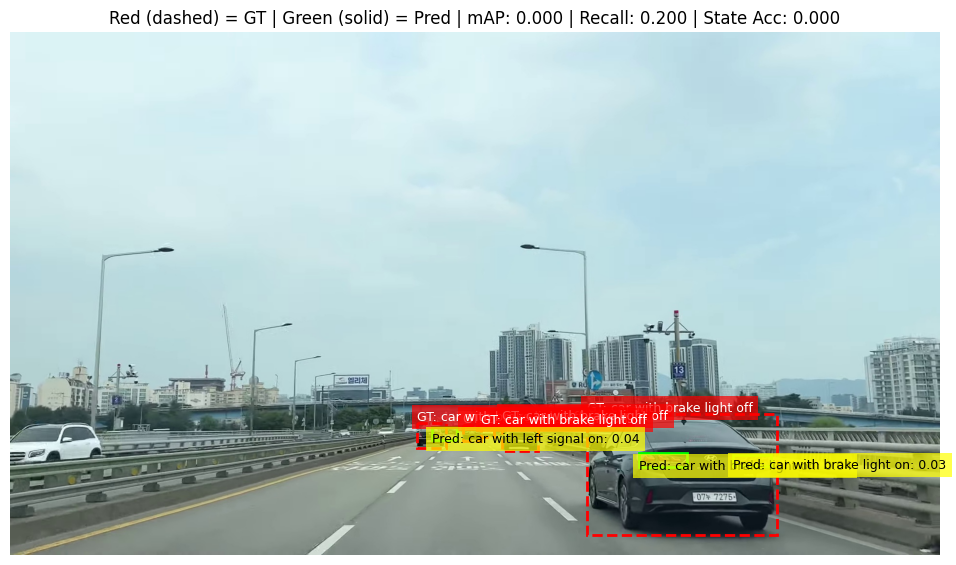


Image 19081: C:\Users\18438\Downloads\TLD-YT-part1\DcOj1FogG1U\DcOj1FogG1U-part5\000002157.jpg

Pretrained model:
  mAP@0.2: 0.1667
  Recall@0.2: 0.2000
  State Accuracy@0.2: 0.5000
  GT boxes: 5 | Pred boxes: 5


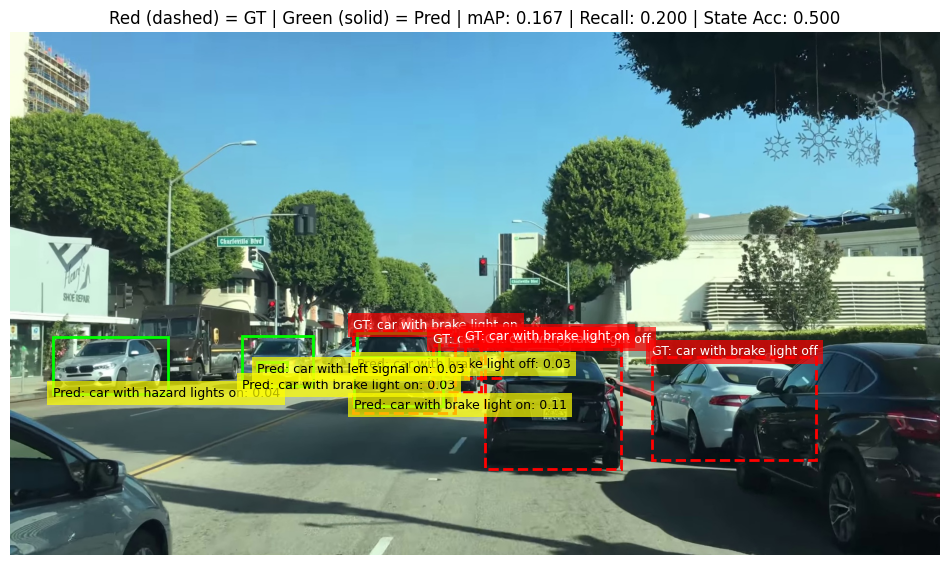


Fine-tuned model:
  mAP@0.2: 0.3750
  Recall@0.2: 0.6000
  State Accuracy@0.2: 0.3333
  GT boxes: 5 | Pred boxes: 17


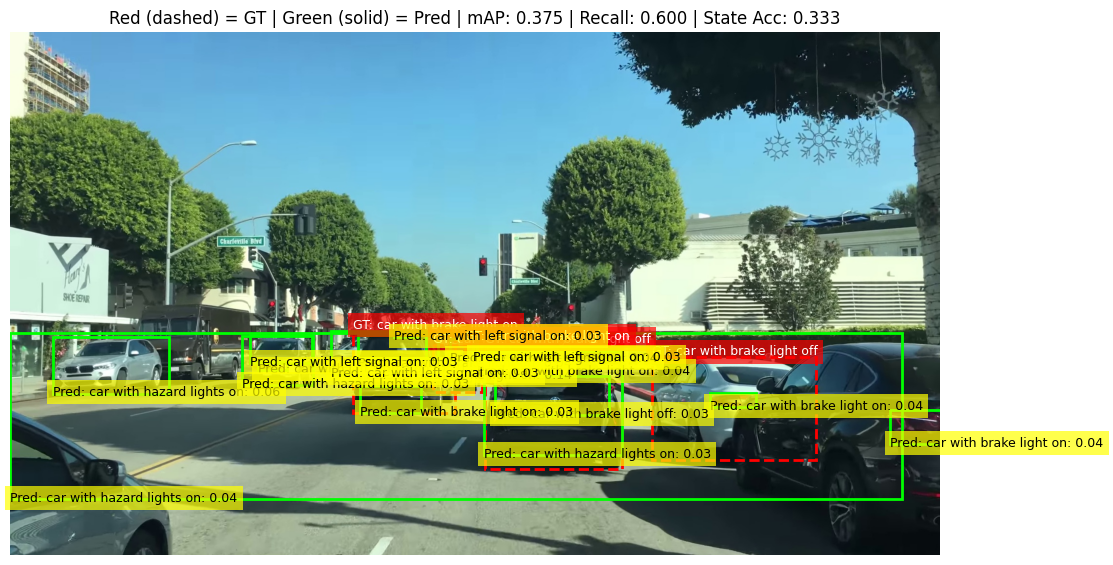

In [78]:
# Get the first 5 validation samples from the dataset
val_dataset = OwlViTDataset(val_records, label_map, min_boxes=1)

# text_queries should already be correctly defined at the top of your file
# Just verify it matches the dataset's label_to_idx order
test_labels = list(label_map.values())


for idx in random.sample(range(len(val_dataset)), k=min(5, len(val_dataset))):
    dataset_item = val_dataset[idx]
    img_path = dataset_item["image_path"]
    
    print(f"\n{'='*60}")
    print(f"Image {idx+1}: {img_path}")
    print('='*60)

    print("\nPretrained model:")
    visualize_owlvit_with_ground_truth(
        processor=processor,
        model=model,
        dataset_item=dataset_item,
        text_queries=test_labels,  # Use the text_queries defined at the top
        threshold=0.03,
        iou_thresh=0.2,
    )

    print("\nFine-tuned model:")
    visualize_owlvit_with_ground_truth(
        processor=finetuned_processor,
        model=finetuned_model,
        dataset_item=dataset_item,
        text_queries=test_labels,  # Use the text_queries defined at the top
        threshold=0.03,
        iou_thresh=0.2,
    )